In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import system libs
import os
import time
import shutil
import itertools
import joblib

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
#!pip install joblib

In [ ]:
metadata=pd.read_csv(os.path.join('/content/drive/MyDrive/skin_dataset/archive/HAM10000_metadata.csv'))
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
#Checking for NA
metadata.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [ ]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [ ]:
metadata = metadata.dropna()

In [ ]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


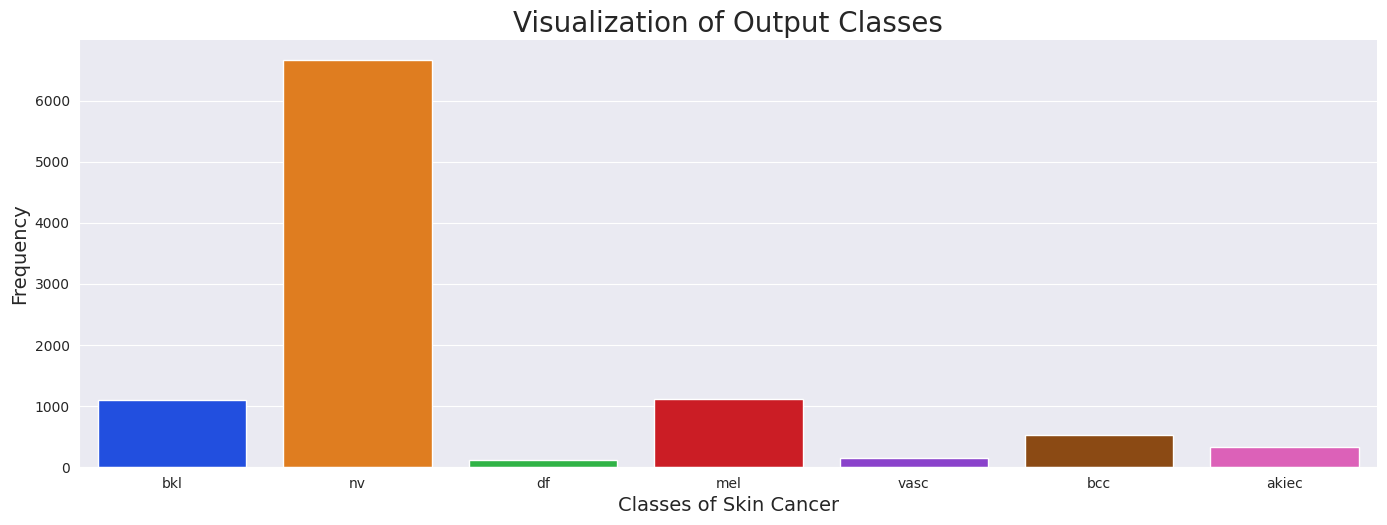

In [ ]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)

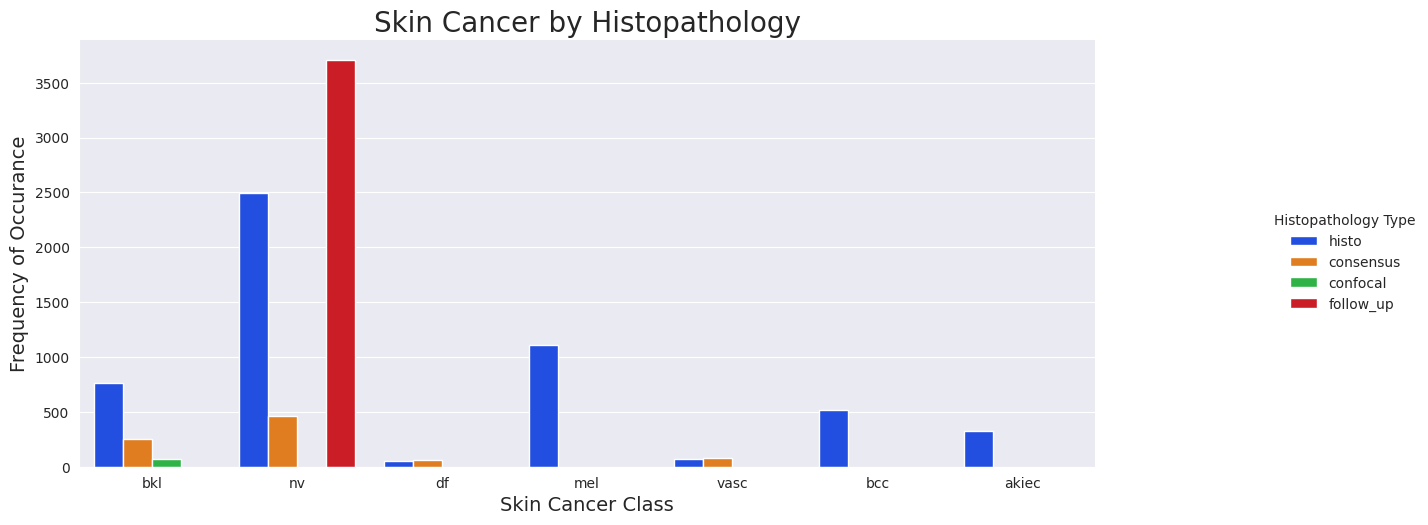

In [ ]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')

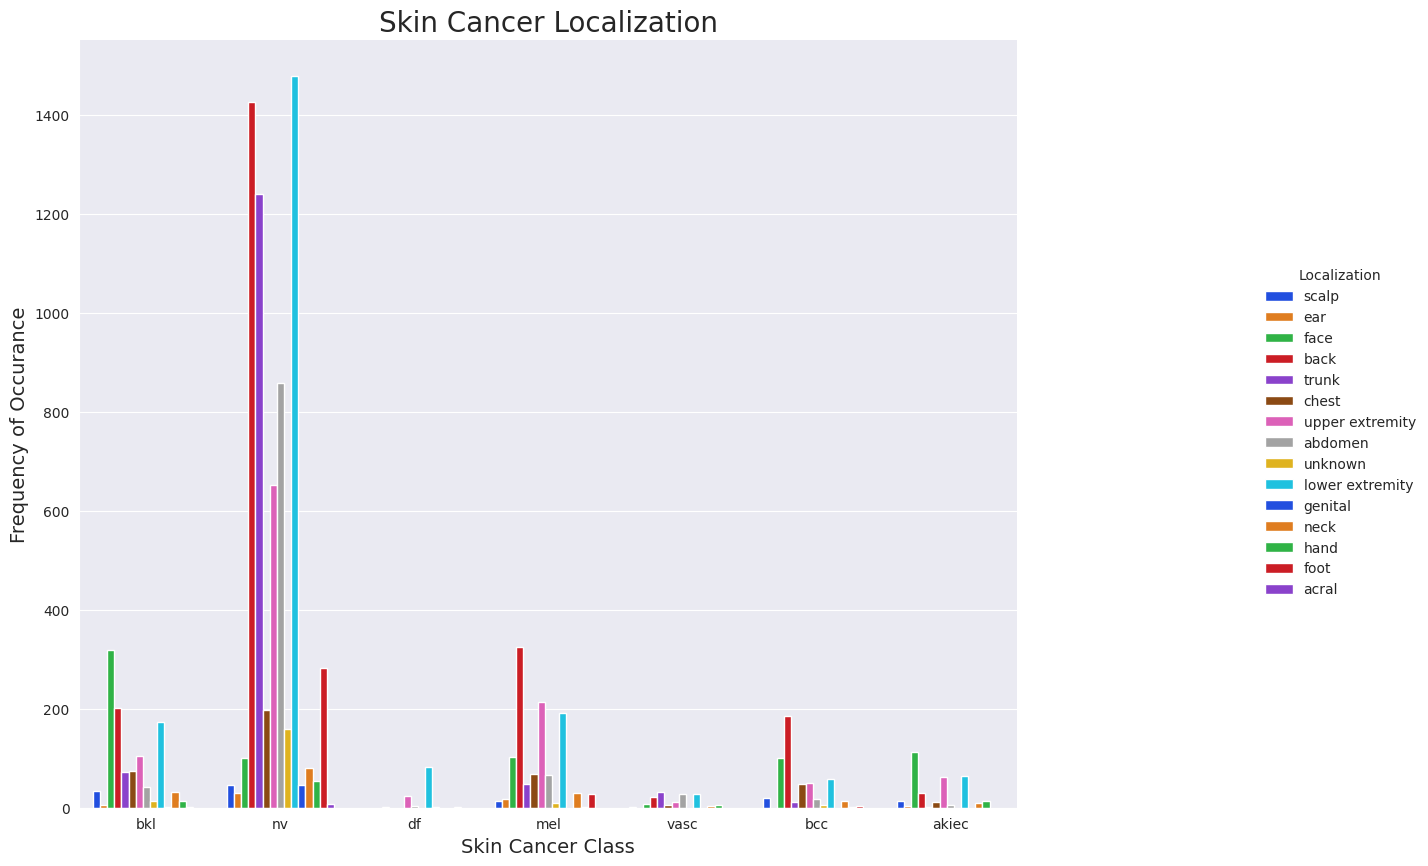

In [ ]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

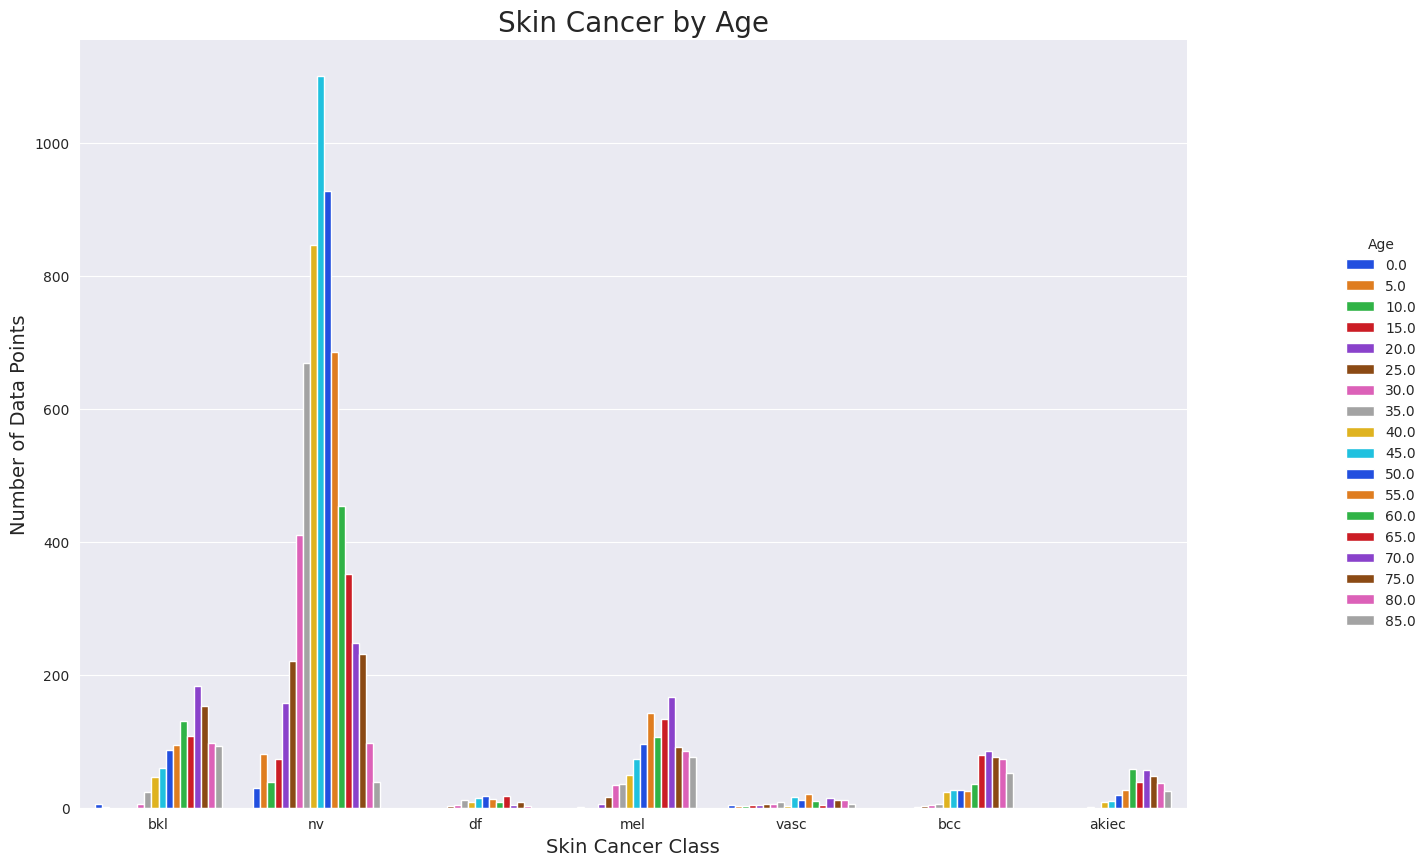

In [ ]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

In [ ]:
data_dir = '/content/drive/MyDrive/skin_dataset/archive/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

x=data.drop('label',axis=1)
y=data['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [ ]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [ ]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

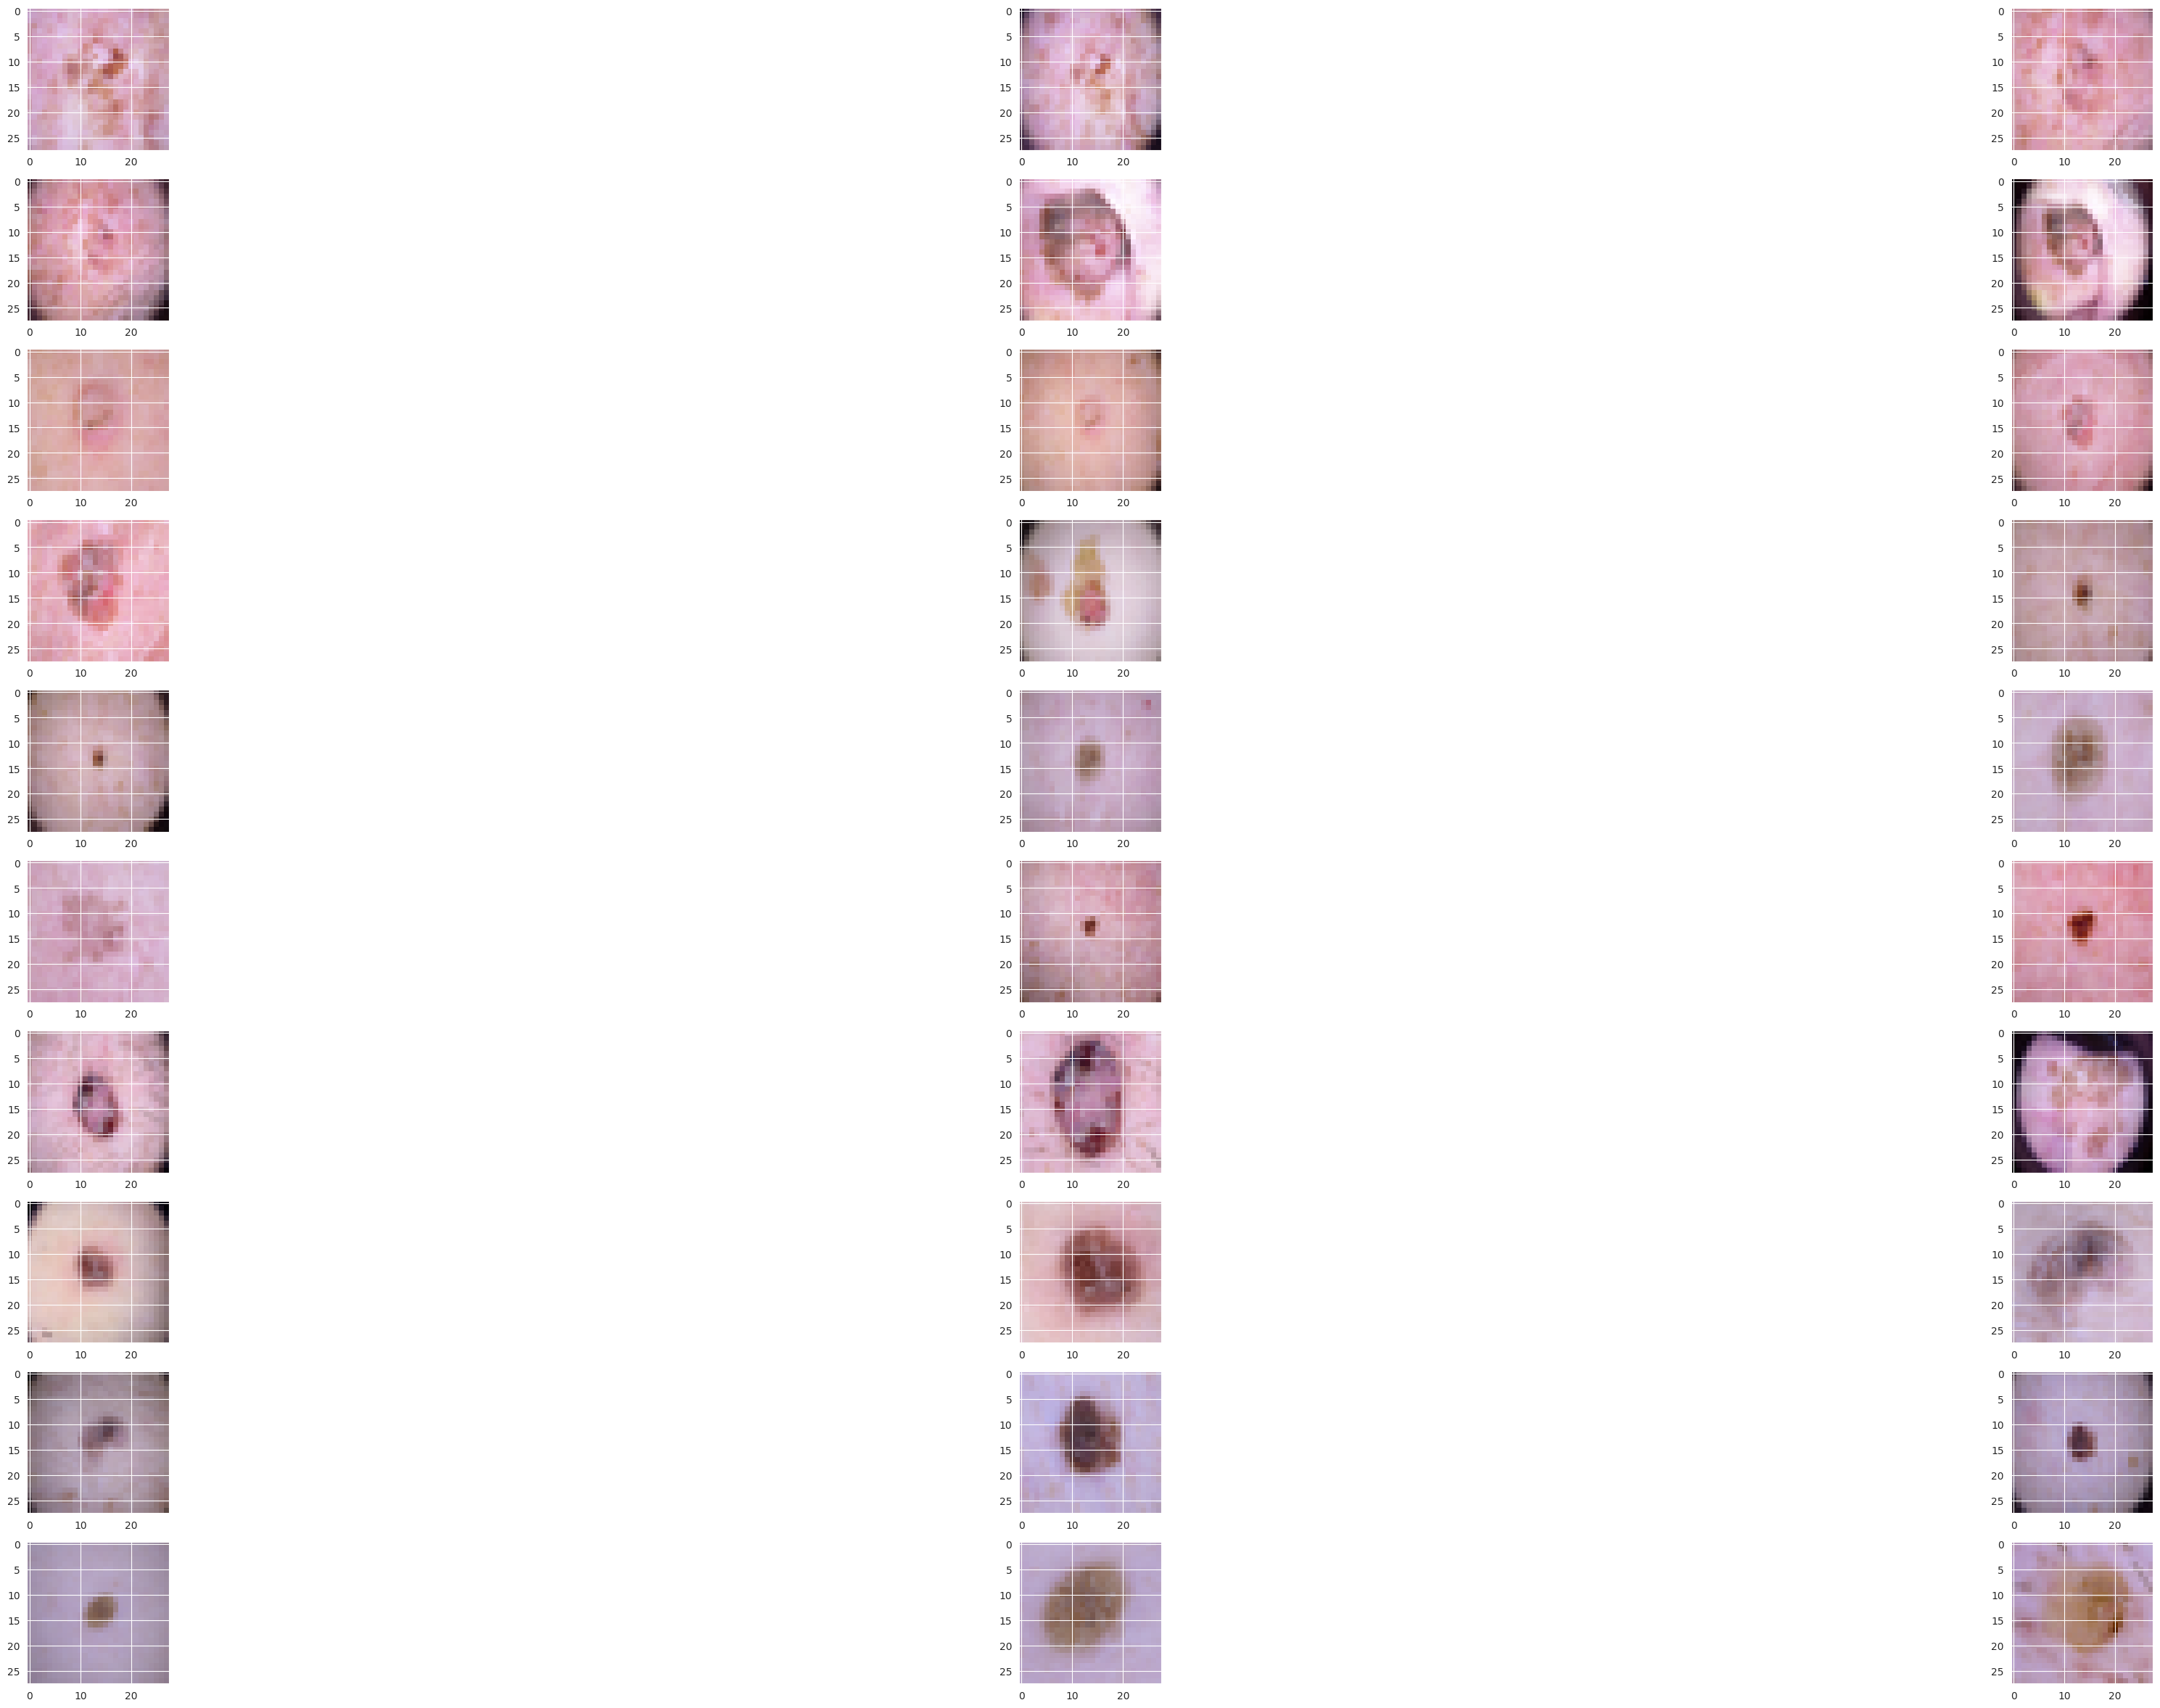

In [ ]:
x=x.reshape(-1,28,28,3)
plt.figure(figsize=(50,30))
for i in range(30):
    plt.subplot(10,3,i+1)
    img=x[i]
    plt.imshow(img)

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [ ]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (35201, 28, 28, 3)
X_test shape: (11734, 28, 28, 3)
y_train shape: (35201,)
y_test shape: (11734,)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [ ]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

model.compile(Adamax(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0

In [ ]:
#train the neural network model
history = model.fit(X_train ,
                    y_train ,
                    epochs=5 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/5
276/276 [==============================] - 250s 891ms/step - loss: 1.2860 - accuracy: 0.4978 - val_loss: 1.8647 - val_accuracy: 0.4017 - lr: 0.0100
Epoch 2/5
276/276 [==============================] - 246s 892ms/step - loss: 0.6777 - accuracy: 0.7490 - val_loss: 1.0807 - val_accuracy: 0.6208 - lr: 0.0100
Epoch 3/5
276/276 [==============================] - 245s 890ms/step - loss: 0.4495 - accuracy: 0.8323 - val_loss: 0.8374 - val_accuracy: 0.7269 - lr: 0.0100
Epoch 4/5
276/276 [==============================] - 246s 892ms/step - loss: 0.3271 - accuracy: 0.8825 - val_loss: 1.0998 - val_accuracy: 0.6910 - lr: 0.0100
Epoch 5/5
276/276 [==============================] - 239s 868ms/step - loss: 0.2526 - accuracy: 0.9087 - val_loss: 0.3228 - val_accuracy: 0.8882 - lr: 0.0100


In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

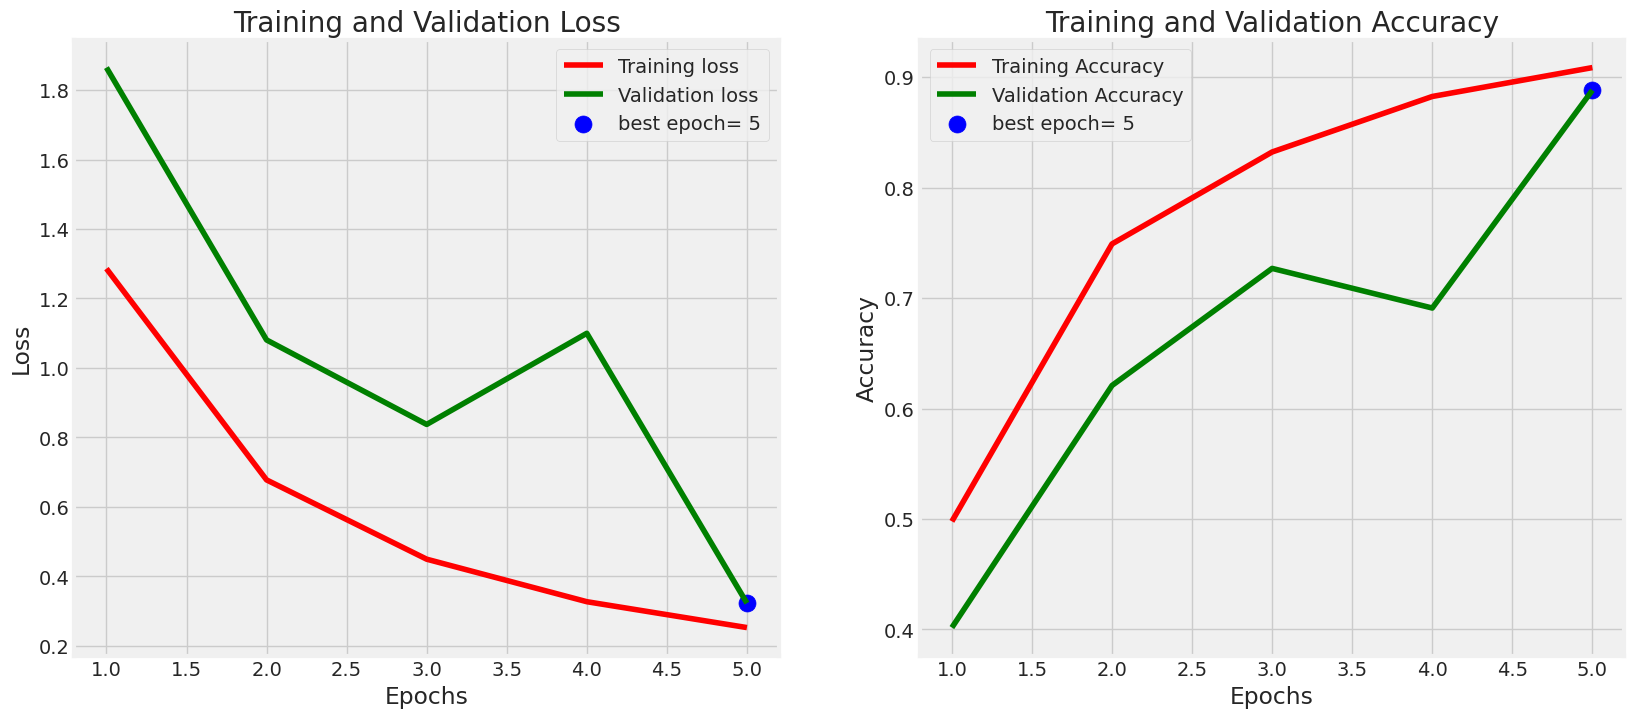

In [ ]:
plot_training(history)

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 20s 56ms/step - loss: 0.3228 - accuracy: 0.8882
Train Loss:  0.2798041105270386
Train Accuracy:  0.9044913649559021
--------------------
Test Loss:  0.3228229284286499
Test Accuracy:  0.8881881833076477


In [ ]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 19s 51ms/step


In [ ]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [ ]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8881881711266405
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1667
           1       0.91      0.95      0.93      1689
           2       0.90      0.76      0.82      1651
           3       0.98      0.98      0.98      1629
           4       0.83      0.69      0.75      1663
           5       0.94      1.00      0.97      1680
           6       0.76      0.86      0.81      1755

    accuracy                           0.89     11734
   macro avg       0.89      0.89      0.89     11734
weighted avg       0.89      0.89      0.89     11734



In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

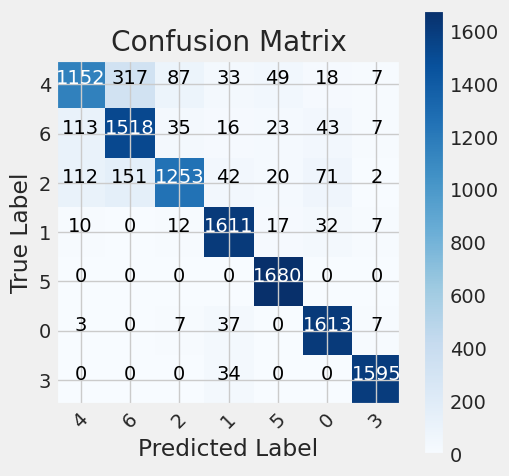

In [ ]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# y_test_unique_classes, y_test_class_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
num = 0
for cls, count in zip(classes_labels, [864, 1699, 1629, 1686, 1625, 1754, 1612]):
    print(f"Class {cls}: {cm[num,num]} from {count} sample, incorrect prediction: {count-cm[num,num]}")
    num += 1

Class 4: 1152 from 864 sample, incorrect prediction: -288
Class 6: 1518 from 1699 sample, incorrect prediction: 181
Class 2: 1253 from 1629 sample, incorrect prediction: 376
Class 1: 1611 from 1686 sample, incorrect prediction: 75
Class 5: 1680 from 1625 sample, incorrect prediction: -55
Class 0: 1613 from 1754 sample, incorrect prediction: 141
Class 3: 1595 from 1612 sample, incorrect prediction: 17


In [ ]:
def convertIMG(testing_img):

    img = Image.open(testing_img)
    img_resized = img.resize((28, 28))
    img_rgb = img_resized.convert('RGB')

    img_array = np.array(img_rgb)

    if img_array.shape[2] == 4:  
        img_array = img_array[:, :, :3]  

    if img_array.shape[:2] != (28, 28):
        raise ValueError("Image size is not as expected")

    return img_array

def getPrediction(testing_img):
    img_input = np.expand_dims(convertIMG(testing_img), axis=0)
    res = np.argmax(model.predict(img_input))

    print(classes[res])

    return res

In [ ]:
from PIL import Image
testing_img = '/content/drive/MyDrive/skin_dataset/archive/HAM10000_images_part_1/ISIC_0024309.jpg'
getPrediction(testing_img)

1/1 [==============================] - 0s 246ms/step
('nv', ' melanocytic nevi')


4

In [ ]:
from PIL import Image
testing_img = '/content/drive/MyDrive/skin_dataset/archive/HAM10000_images_part_1/ISIC_0024539.jpg'
getPrediction(testing_img)

1/1 [==============================] - 0s 28ms/step
('akiec', 'Actinic keratoses and intraepithelial carcinomae')


0

In [ ]:
from PIL import Image
testing_img = '/content/drive/MyDrive/skin_dataset/archive/HAM10000_images_part_1/ISIC_0025303.jpg'
getPrediction(testing_img)

1/1 [==============================] - 0s 27ms/step
('mel', 'melanoma')


6

In [ ]:
from PIL import Image
testing_img = '/content/drive/MyDrive/skin_dataset/archive/HAM10000_images_part_2/ISIC_0029306.jpg'
getPrediction(testing_img)

1/1 [==============================] - 0s 24ms/step
('nv', ' melanocytic nevi')


4

In [ ]:
#joblib.dump(model, 'skin_classification.joblib')

In [ ]:
model.save("/content/drive/MyDrive/skin_dataset/archive/model.h5")
